In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gzip

from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn.metrics import classification_report

In [3]:
img_cols = img_rows = 28
path = 'dataset//mnist//'
model_path = 'Net//net'

In [4]:
def load_data(path, is_test_data):
    if is_test_data:
        fn_x = 'tst_images.gz'
        fn_y = 'tst_labels.gz'
    else:
        fn_x = 'trn_images.gz'
        fn_y = 'trn_labels.gz'
    with gzip.open(path + fn_x, 'r') as f:
        f.read(4)
        img_count = int.from_bytes(f.read(4), 'big')
        rows_ = int.from_bytes(f.read(4), 'big')
        col_ = int.from_bytes(f.read(4), 'big')
        x = f.read(img_rows * img_cols * img_count)
        x = np.frombuffer(x, dtype = np.uint8)
    with gzip.open(path + fn_y, 'r') as f:
        f.read(4)
        label_count = int.from_bytes(f.read(4), 'big')
        y = f.read(label_count)
        y = np.frombuffer(y, dtype = np.uint8)
    x = x.reshape(-1, img_rows * img_cols)
    y = np.array(y, dtype = 'int64') 
    return x, y

In [5]:
def prepare_data(x, y):
    x = np.array(x, dtype='float32') / 255
    x = x.reshape(-1, 1, img_cols, img_rows)
    data = [[x_item, y_item] for x_item, y_item in zip(x, y)]
    data_batch = DataLoader(data, batch_size=128, shuffle=True)
    return data_batch

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.ep = 0
        self.bn = nn.BatchNorm2d(1)
        self.conv = nn.Conv2d(1, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop = nn.Dropout(0.3)
        self.fc0 = nn.Linear(2704, 512)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.xavier_normal_(self.fc0.weight)
        nn.init.xavier_normal_(self.fc1.weight)
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.pool(x)
        x = self.drop(x)
        x = F.relu(x)
        x = x.view(-1, 2704)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        out = x
        return out

In [7]:
def train(net, epochs, train_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for ep in range(epochs):
        net.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for batch_n, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            train_loss += loss.item() * data.size(0)
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()

        net.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = net(data)
                loss = criterion(output, target)
                test_loss += loss.item() * data.size(0)

                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)
        train_accuracy = 100. * correct_train / total_train
        test_accuracy = 100. * correct_test / total_test

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{ep+1}/{epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

In [8]:
x_train, y_train = load_data(path, is_test_data=False)
x_test, y_test = load_data(path, is_test_data=True)
train_batch = prepare_data(x_train, y_train)
test_batch = prepare_data(x_test, y_test)

In [9]:
net = Net()

Epoch [1/13], Train Loss: 0.3991, Train Accuracy: 87.59%, Test Loss: 0.1047, Test Accuracy: 96.81%
Epoch [2/13], Train Loss: 0.1092, Train Accuracy: 96.67%, Test Loss: 0.0781, Test Accuracy: 97.57%
Epoch [3/13], Train Loss: 0.0773, Train Accuracy: 97.68%, Test Loss: 0.0580, Test Accuracy: 98.33%
Epoch [4/13], Train Loss: 0.0717, Train Accuracy: 97.88%, Test Loss: 0.0728, Test Accuracy: 97.92%
Epoch [5/13], Train Loss: 0.0701, Train Accuracy: 97.95%, Test Loss: 0.0701, Test Accuracy: 97.95%
Epoch [6/13], Train Loss: 0.0626, Train Accuracy: 98.23%, Test Loss: 0.0657, Test Accuracy: 98.11%
Epoch [7/13], Train Loss: 0.0649, Train Accuracy: 98.14%, Test Loss: 0.0663, Test Accuracy: 98.20%
Epoch [8/13], Train Loss: 0.0592, Train Accuracy: 98.28%, Test Loss: 0.0680, Test Accuracy: 98.11%
Epoch [9/13], Train Loss: 0.0586, Train Accuracy: 98.42%, Test Loss: 0.0761, Test Accuracy: 98.17%
Epoch [10/13], Train Loss: 0.0602, Train Accuracy: 98.31%, Test Loss: 0.1192, Test Accuracy: 97.78%
Epoch [11

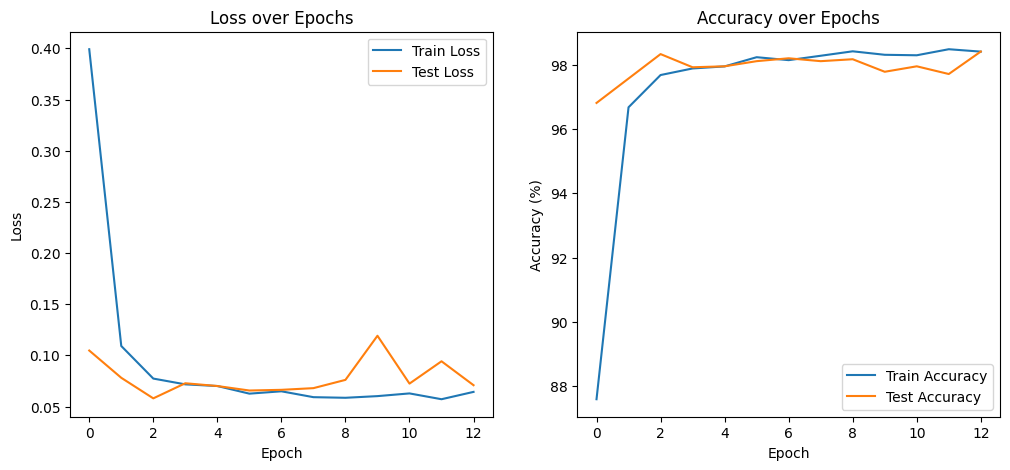

In [10]:
train(net, 13, train_batch, test_batch)

In [11]:
torch.save(net.state_dict(), model_path)